This example is created by *Shuvashish Mondal* using the data and the equation from *"Nonlinear Regression Analysis and Its Applications - 1988 - Bates"* p.33 Example

**Equation:**  
    $$f(x, \theta) = \frac{\theta_1x}{\theta_2 + x}$$  
where,  
$\qquad f(x, \theta)\rightarrow$ reaction velocity (response / output variable)  
$\qquad \theta_1, \theta_2 \rightarrow$ parameters  
$\qquad x\rightarrow$ substrate concentration (control / decision variable)  

**Data:**  
<table>
  <thead>
    <tr>
      <th>Substrate</th>
      <th colspan="2">Velocity</th>
    </tr>
    <tr>
      <th>Concentration</th>
      <th colspan="2">(counts/min<sup>2</sup>)</th>
    </tr>
    <tr>
      <th>(ppm)</th>
      <th>(a) Treated</th>
      <th>(b) Untreated</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0.02</td>
      <td style="vertical-align: top; text-align: center;">76 <br> 47</td>
      <td style="vertical-align: top; text-align: center;">67 <br> 51</td>
    </tr>
    <tr>
      <td>0.06</td>
      <td style="vertical-align: top; text-align: center;">97 <br> 107</td>
      <td style="vertical-align: top; text-align: center;">84 <br> 86</td>
    </tr>
    <tr>
      <td>0.11</td>
      <td style="vertical-align: top; text-align: center;">123 <br> 139</td>
      <td style="vertical-align: top; text-align: center;">98 <br> 115</td>
    </tr>
    <tr>
      <td>0.22</td>
      <td style="vertical-align: top; text-align: center;">159 <br> 152</td>
      <td style="vertical-align: top; text-align: center;">131 <br> 124</td>
    </tr>
    <tr>
      <td>0.56</td>
      <td style="vertical-align: top; text-align: center;">191 <br> 201</td>
      <td style="vertical-align: top; text-align: center;">144 <br> 158</td>
    </tr>
    <tr>
      <td>1.10</td>
      <td style="vertical-align: top; text-align: center;">207 <br> 200</td>
      <td style="vertical-align: top; text-align: center;">160</td>
    </tr>
  </tbody>
</table>

# Importing packages

In [1]:
import numpy as np
# import seaborn as sns  # This package is only needed for pairplot
import matplotlib.pyplot as plt
import pyomo.environ as pyo
from pyomo.contrib.parmest import parmest
from pyomo.contrib.parmest.experiment import Experiment
from pyomo.contrib.doe import DesignOfExperiments
import pandas as pd
from itertools import product
import idaes

# Data
Let's make a dictionary of the data from the table above. We can see from the data that for each substrate concentration 2 measurement data were collected. So we will take their average in our calculation

In [2]:
substrate_concentration = [0.02, 0.06, 0.11, 0.22, 0.56, 1.10]

treated_velocity = [
    [76, 47], 
    [97, 107], 
    [123, 139], 
    [159, 152], 
    [191, 201], 
    [207, 200]]
untreated_velocity = np.array([
    [67, 51], 
    [84, 86], 
    [98, 115], 
    [131, 124], 
    [144, 158], 
    [160, np.nan]]
                             )

# calculate the average velocity. we are taking the average horizontally / along the rows. axis =1
treated_avg_velocity = np.nanmean(treated_velocity, axis = 1)  
treated_measurement_error = np.std(treated_velocity)
untreated_avg_velocity = np.nanmean(untreated_velocity, axis = 1)

data_f = {
    "substrate_concentration": substrate_concentration,
    "treated_avg_velocity": treated_avg_velocity,
    "untreated_avg_velocity": untreated_avg_velocity
       }

# Organizing the data in a ``list`` consisting of ``dict``s of ``one key : one value``
data_treated = [
    {"substrate_concentration" : float(sub_conc), "avg_velocity": float(treated_vel)} 
    for sub_conc, treated_vel in zip(data_f["substrate_concentration"], data_f["treated_avg_velocity"])
]

data_untreated = [
    {"substrate_concentration" : float(sub_conc), "avg_velocity": float(untreated_vel)} 
    for sub_conc, untreated_vel in zip(data_f["substrate_concentration"], data_f["untreated_avg_velocity"])
]


# PARMEST & DOE

## Creating an experiment class for both DOE and ParmEst

In [3]:
class ReactionVelocity(Experiment):

    # Defining the constructor for our model
    def __init__(self, data, theta_initial=None):
        """
        Arguments:
            data: data from our experiment. type: 'dict'
            theta_initial: initial guess of the parameter values, dtype: dict. pass the values as theta_initial = {1 : <theta_1 initial value>, 2 : <theta_2 initial value>}
                default:  {1: 100, 2: 0.05}
                
        """
        self.conc = data["substrate_concentration"]
        self.vel = data["avg_velocity"]
        self.model = None  
        self.theta_initial = theta_initial
        if self.theta_initial is None:
            self.theta_initial = {1: 100, 2: 0.05}  # default initial guess of theta[1] & theta[2]
        else:
            self.theta_initial = theta_initial

    # Creating the get_labeled_model which is a must for ``DOE`` and ``ParmEst``
    def get_labeled_model(self):
        if self.model is None:
            self.create_model()
            self.label_model()
            self.finalize_model()
        return self.model

    
    def create_model(self):
        """
        Here, we will create different variables, parameters, and constraints
        """
        m = self.model = pyo.ConcreteModel()

        # theta_1
        m.theta_1 = pyo.Var(domain = pyo.NonNegativeReals, initialize = self.theta_initial[1])
        m.theta_2 = pyo.Var(domain = pyo.NonNegativeReals, initialize = self.theta_initial[2])

        # substrate concentration (x) as a param, since the data is given          
        m.x = pyo.Var(domain = pyo.NonNegativeReals, initialize = self.conc)
        m.reaction_velocity = pyo.Var(domain = pyo.NonNegativeReals)

        # reaction_velocity = f(substrate_concentration, theta), is obtained from this equation.
        # So we will set it as an ``Expression``
        # m.reaction_velocity = pyo.Expression(expr = m.theta[1] * m.x / (m.theta[2] + m.x))        
        @m.Constraint()  # since the ``Constraint`` is not a set of anything, so there is no argument
        def vel_con(m):
            return m.reaction_velocity == m.theta_1 * m.x / (m.theta_2 + m.x)

        # m.con = pyo.Constraint(rule = vel_con)  

        # ======================================
        # Objective function
        """
        When I used the built in ``"SSE"``in parmest ``Estimator``, my model could not find LR ratio.
        That's why I created the ``Total_Cost_Obj`` to minimize the SSE. You can ignore this and use default "SSE". 
        Both ``FirstStageCost`` and ``SecondStageCost`` are required for the ``Objective``, otherwise it will show ``AttributeError``
        """
        
        # Stage-specific cost computation
        m.FirstStageCost = pyo.Expression(initialize = 0)
        m.SecondStageCost = pyo.Expression(expr = (self.vel - m.reaction_velocity) ** 2)

        m.Total_Cost_Obj = pyo.Objective(expr = (m.FirstStageCost + m.SecondStageCost), sense = pyo.minimize)
        # ======================================

            
        # m.pprint()
        
        return m

    
    def finalize_model(self):
        """
        Finalizing the model. Here, we will set the experimental conditions (e.g, initial conditions),
        fixing the parameter values (if needed), update `t` values, and discretize the model (if model is dynamic). 
        It makes a solvable model.
        """        
        m=self.model

        # fixing the parameters
        m.theta_1.fix(self.theta_initial[1]) 
        m.theta_2.fix(self.theta_initial[2]) 

        # Add lower and upper bound to substrate concentration (control variable)
        m.x.setlb(0)
        m.x.setub(20)

        # fixing the substrate concentration (control variable)
        m.x.fix(self.conc)

        return m

    
    def label_model(self):
        """
        The model is updated with outputs, and unknown parameters. This makes the model labeled with full experiment.
        In `ParmEst` output (given data) is the most important. For `DOE` input is most important.
        """
        m = self.model

        m.experiment_outputs = pyo.Suffix(direction = pyo.Suffix.LOCAL)  
        m.experiment_outputs.update([(m.reaction_velocity, self.vel)])  # Pass the data as a list of `tuple`
        # If we only use ``DOE``, we could use ``m.experiment_ouputs.update([(m.x, None)])``.
        # Output is not important for ``DOE``

        m.experiment_inputs = pyo.Suffix(direction = pyo.Suffix.LOCAL)    
        # m.experiment_inputs[m.x] = self.conc
        m.experiment_inputs.update([(m.x, self.conc)])
        # If we only use ``DOE``, we could use ``m.experiment_inputs.update([(m.x, None)])``

        m.unknown_parameters = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        m.unknown_parameters.update((p, pyo.value(p)) for p in [m.theta_1, m.theta_2])
        # m.unknown_parameters[m.theta_1]= self.theta_initial[1]
        # m.unknown_parameters[m.theta_2]= self.theta_initial[2]

        m.measurement_error = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        # m.measurement_error[m.reaction_velocity] = 0.03
        m.measurement_error.update([(m.reaction_velocity, 0.03**2)])  # variance of the measurement error, b/c in doe, the measurement error is passed as variance, not std
        # this will be fixed in later update 

        return m

## Parmest Example
We will evaluate diffent parameters, visualize pairwise plots and show bootstrap table

### Treated velocity
Here, we will calculate objective value at optimum parameter value, paramater values, $\theta$, and covariance matrix for treated velocity.

In [4]:
exp_list = []  
conc = substrate_concentration
vel = treated_avg_velocity
n_exp = len(data_treated)

# exp_list to separate each experiment
for i in range(n_exp):
    exp_list.append(ReactionVelocity(data_treated[i]))

# Creating an Estimator object
pest = parmest.Estimator(exp_list, tee = False)  

# Estimating d
obj, theta, cov = pest.theta_est(calc_cov=True, cov_n=n_exp)

# ``parmest`` can mess up the order of the theta estimates and also the covariance. So we need to fix the order so that we can manipulate it properly.
t_order = ["theta_1", "theta_2"]
theta_perm = theta.loc[t_order]  # ``theta`` in the order we want
cov_perm = cov.loc[t_order, t_order]  # ``covariance`` matrix in the order we want

print("\ntheta values:")
print(theta_perm)

print("\nSSE value: ", obj)

print("\nCovariance matrix:")
print(cov_perm)


theta values:
theta_1    212.683743
theta_2      0.064121
dtype: float64

SSE value:  41.495734536613284

Covariance matrix:
           theta_1   theta_2
theta_1  47.672886  0.041806
theta_2   0.041806  0.000065


### Untreated velocity
Here, we will calculate objective value at optimum parameter value, paramater values, $\theta$, and covariance matrix for untreated velocity.

In [5]:
exp_list = []  
n_exp = len(data_untreated)

# exp_list to separate each experiment
for i in range(n_exp):
    exp_list.append(ReactionVelocity(data_untreated[i]))

# Creating an Estimator object
pest = parmest.Estimator(exp_list, tee = False)  

# obj, theta = pest.theta_est()
obj_u, theta_u, cov_u = pest.theta_est(calc_cov=True, cov_n=n_exp)

# ``parmest`` can mess up the order of the theta estimates and also the covariance. So we need to fix the order so that we can manipulate it properly.
t_order = ["theta_1", "theta_2"]
theta_ordered_u = theta_u.loc[t_order]  # ``theta`` in the order we want
cov_ordered_u = cov_u.loc[t_order, t_order]  # ``covariance`` matrix in the order we want

print("\n\ntheta values:")
print(theta_ordered_u)

print("\nSSE value: ", obj_u)

print("\nCovariance matrix:")
print(cov_ordered_u)



theta values:
theta_1    162.214170
theta_2      0.049467
dtype: float64

SSE value:  41.08777008727722

Covariance matrix:
           theta_1   theta_2
theta_1  39.567323  0.036410
theta_2   0.036410  0.000064


### Likelyhood ratio 
In this subsection, we willl calculate the likelihood ratio of our $\theta$ values. This will take 1 minute or so depending on the number data points

In [6]:
# # creating theta values where we want to find the LR
# theta_1 = np.linspace(150, 250, 10)
# theta_2 = np.linspace(0.03, 0.07, 10)

# # creating a DF using these theta values
# theta_vals = pd.DataFrame(
#     list(product(theta_1, theta_2)), columns=["theta_1", "theta_2"]  
#     # Names of the theta values as we defined in ``create_model``. our theta was basically a ``dict``
# )

# # Objective values for each theta value. Pre-requiste method for ``likelihood_ratio_test``
# obj_at_theta = pest.objective_at_theta(theta_vals)

# # Likelihood Ratio Test : to identify theta values within a confidence region using the distribution
# LR = pest.likelihood_ratio_test(obj_at_theta, obj, [0.8, 0.85, 0.9, 0.95]) # The [0.8, 0.85, 0.9, 0.95] list is  alpha values (Confidence Level) for `chi2`` test
# # the ``obj` here is from ``obj, theta, cov = pest.theta_est(calc_cov=True, cov_n=n_data)``.


### Pairwise_plot (theta values - confidence level)
Create plot pairwise relationship for theta values, and optionally alpha-level confidence intervals and objective value contours

In [7]:
# # `theta` here is from ``obj, theta, cov = pest.theta_est(calc_cov=True, cov_n=n_data)``.
# parmest.graphics.pairwise_plot(LR, theta, 0.95, title= "Likelihood Ratio results within 95% confidence region")
# # the blue dots (``thetas``), represent the values at which the ``LR`` is true with the mentioned confidence level


### bootstrap
we will bootstrap for our $\theta$ values here and then plot the bootstrapped values in a parmest pairplot which actually uses `seaborn` in the background

In [8]:
# pest = parmest.Estimator(exp_list)
# bootstrap_theta = pest.theta_est_bootstrap(50, seed=4581)

In [9]:
# parmest.graphics.pairwise_plot(bootstrap_theta, theta, title='Bootstrap theta')
# parmest.graphics.pairwise_plot(
#     bootstrap_theta,
#     theta,
#     0.95,
#     ['MVN', 'KDE', 'Rect'],
#     title='Bootstrap theta with 95% confidence regions',
# )

## DOE Example
We will compute the Fisher Information Matrix (FIM), covariance matrix and then use Full Factorial Design

### FIM and Parameter Covariance
Let's first convert the parameter values (`theta_perm`) that we got from `parmest` to a dictionary so that we can use that as an argument when we use the `class` of our model and then use `DOE`

In [6]:
theta_initial = {1: theta_ordered_u["theta_1"], 2: theta_ordered_u["theta_2"]}
data = data_untreated

In [7]:
def run_reactor_doe(design_ranges):
    """
    Argument:
    design_ranges: a `list`. [start, stop, number_of_points]. This argument is required for full factorial design. 
    """
    FIM = []
    for i in range(n_exp):
        # Create a ReactorVelocity object for each experiment
        experiment = ReactionVelocity(data[i], theta_initial=theta_initial)

        scale_nominal_param_value = False
        doe_obj = DesignOfExperiments(
            experiment,
            scale_nominal_param_value=scale_nominal_param_value,
            tee=False
        )        
        # I haven't passed the other arguments, because the defaults values are used in the doe example.
        
        FIM.append(doe_obj.compute_FIM())

    # Let's sum up the FIM to get the total FIM of all the experiments
    FIM_sum = np.array(FIM).sum(axis=0)

    # Make design ranges to compute the full factorial design
    design_ranges = {"x" : design_ranges}   # this `key` needs to have the same name as the design variable we defined in our `class`

    # Compute the full factorial design  with the sequential FIM calculation
    FF = doe_obj.compute_FIM_full_factorial(design_ranges = design_ranges, method = "sequential")
    
    # plot the results
    doe_obj.draw_factorial_figure(
    sensitivity_design_variables= ["x"],  # this `sensitivity_design_variables` name needs to have the same name as the design variable we defined in our `class`
    fixed_design_variables= {},  # What to put as `fixed_design_variables` for single design variable model.
    title_text = "Full factorial design of Michaelis Menten model",
    xlabel_text= "Substrate Concentration",
    log_scale= False,
    figure_file_name= "Michaelis Menten"
)
        
    # return the `Full factorial` of our design ranges and `FIM` of the experiments   
    return FF, FIM_sum

Let's call our function `run_reactor_doe` and plot using the DOE method `draw_factorial_figure()`

/Users/shuvashishmondal/Documents/GitHub/pyomo/pyomo/contrib/doe/doe.py:1526: RuntimeWarning: invalid value encountered in log10
  D_opt = np.log10(np.linalg.det(FIM))



Cov of theExperiment using ``DOE``
 [[6.19677823e-04 6.04961693e-07]
 [6.04961693e-07 1.05845612e-09]]
3.761183023452759


,x,log10 D-opt,log10 A-opt,log10 E-opt,log10 ME-opt,eigval_min,eigval_max,det_FIM,trace_FIM,solve_time
0,0.001000,NaN,6.653913,NaN,19.121109,-2.932359e-17,4.507265e+06,-5.214605e-11,4.507265e+06,0.082368
1,0.069931,-5.253891,8.847290,-13.875622,18.640863,1.331612e-14,7.035414e+08,5.573256e-06,7.035414e+08,0.082857
2,0.138862,NaN,8.651435,-13.343316,18.296622,4.536119e-14,4.481624e+08,-2.489801e-05,4.481624e+08,0.082771
3,0.207793,-4.511640,8.459710,NaN,18.262495,-3.168194e-14,2.882107e+08,3.078645e-05,2.882107e+08,0.082701
4,0.276724,NaN,8.296143,NaN,19.104458,-8.753808e-14,1.977622e+08,-1.761122e-06,1.977622e+08,0.088176
5,0.345655,NaN,8.156299,NaN,19.036439,-9.783020e-14,1.433175e+08,-2.470494e-05,1.433175e+08,0.083908
6,0.414586,-5.195691,8.034898,-12.689120,18.385919,2.045878e-13,1.083672e+08,6.372486e-06,1.083672e+08,0.082723
7,0.483517,-4.778086,7.927907,-13.139215,18.893021,7.257471e-14,8.470458e+07,1.666917e-05,8.470458e+07,0.081350
8,0.552448,NaN,7.832383,NaN,17.782541,-1.589560e-13,6.798036e+07,-9.581983e-06,6.798036e+07,0.081213
9,0.621379,NaN,7.746164,NaN,18.241923,-4.537003e-14,5.573968e+07,-3.332394e-06,5.573968e+07,0.079121


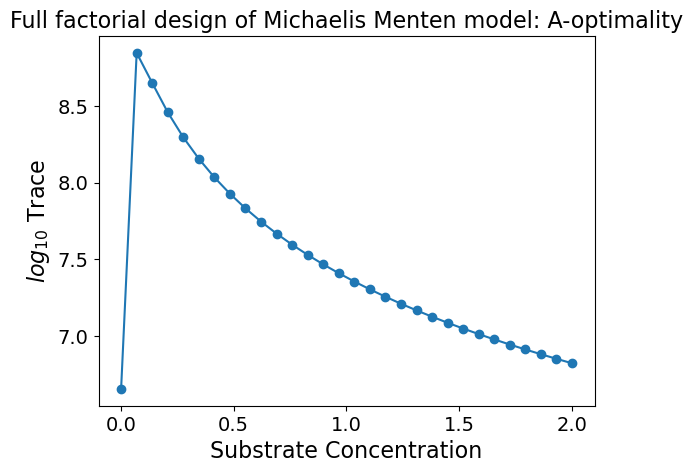

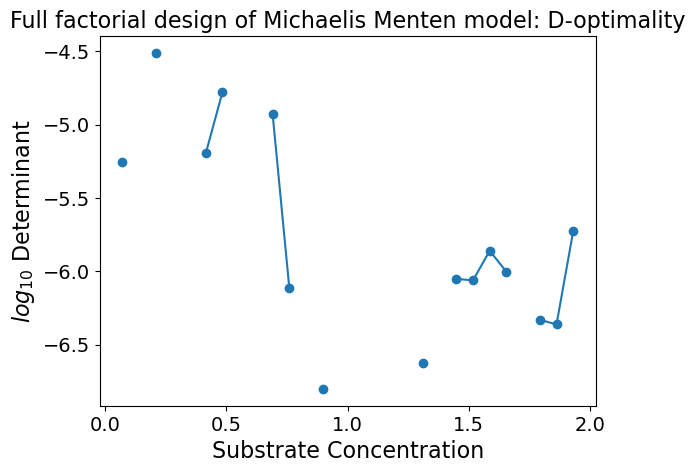

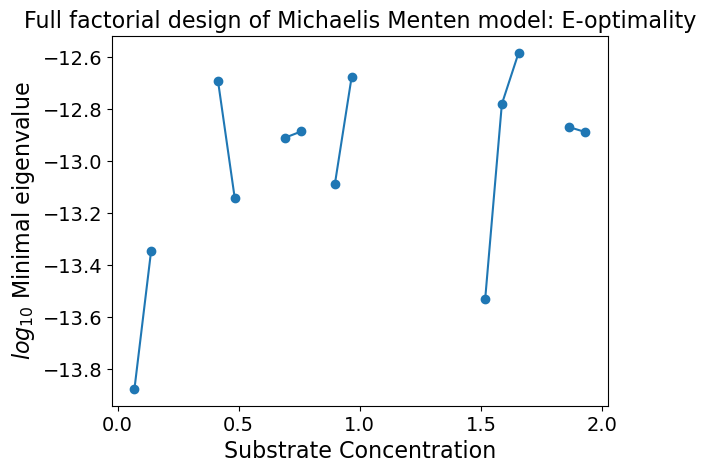

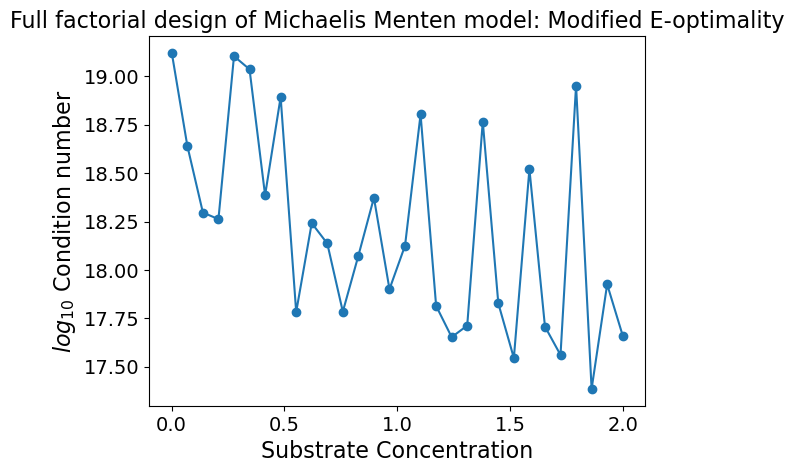

In [21]:
from pyomo.contrib.doe import DesignOfExperiments
import time
start = time.time()
FullFactorial_result, FIM =  run_reactor_doe([0.001, 2, 30])   
cov_doe = np.linalg.inv(FIM)
print("\nCov of theExperiment using ``DOE``\n", cov_doe)
ff_df = pd.DataFrame(FullFactorial_result)
end = time.time()
total_time = end - start
print(total_time)
ff_df

From the above result we can see that `A-optimality` suggested substrate concentration 0.2 ppm to be the best informative experiment, while `D-optimality` recommended 0.65 ppm to be the next best experiment. `ME-optimality` suggested 1.1 ppm. There is a problem with the `E-optimality`.  
Now, let's see the result of our `compute_FIM_full_factorial()`. Instead of using `draw_factorial_figure()` we can also create and customize plots using this result.

In [13]:
x = FullFactorial["x"]
y = FullFactorial['log10 D-opt']
plt.plot(x, y, "o-")

NameError: name 'FullFactorial' is not defined

In [ ]:
np.linalg.eigh(FIM)

In [ ]:
FullFactorial_result

# Reparameterization  
Since the ratio of the parameter values $\theta_1 / \theta_2$ is around 3300, $\theta_1$ is very much insensitive to responses compared to $\theta_2$. So, it is probably a good idea to reparameterize this.  
**Equation:**  
    $$f(x, \theta) = \frac{\theta_1x}{\theta_2 + x}$$  
    Let's reparameterize this to-
    $$\frac{1}{f} = \frac{1}{\theta_1} + \frac{\theta_2}{\theta_1}\frac{1}{x}$$
    $$=\beta_1 + \beta_2 \, u$$
Now, this equation has become linear which is easier to deal with. **However, now we need information about measurement error for 1/f, not for f. So the measurement error in this case won't be the same as before.**

## Class
We will implement this reparameterization in our model.

In [ ]:
class ReactionVelocity_wrp(Experiment):

    # Defining the constructor for our model
    def __init__(self, data, beta_initial=None):
        """
        Arguments:
            data: data from our experiment. type: 'dict'
            beta_initial: initial guess of the parameter values, dtype: dict. pass the values as beta_initial = {1 : <beta_1 initial value>, 2 : <beta_2 initial value>}
                default:  {1: 0.004701816815995802, 2: 0.00030148652047799746}
                
        """
        self.conc = data["substrate_concentration"]
        self.vel = data["avg_velocity"]
        self.model = None  
        self.beta_initial = beta_initial
        if self.beta_initial is None:
            self.beta_initial = {1: 0.0047, 2: 0.0003}  # default initial guess of beta[1] & beta[2]
        else:
            self.beta_initial = beta_initial

    # Creating the get_labeled_model which is a must for ``DOE`` and ``ParmEst``
    def get_labeled_model(self):
        if self.model is None:
            self.create_model()
            self.label_model()
            self.finalize_model()
        return self.model

    
    def create_model(self):
        """
        Here, we will create different variables, parameters, and constraints
        """
        m = self.model = pyo.ConcreteModel()

        # beta_1
        m.beta_1 = pyo.Var(domain = pyo.NonNegativeReals, initialize = self.beta_initial[1])
        m.beta_2 = pyo.Var(domain = pyo.NonNegativeReals, initialize = self.beta_initial[2])

        # substrate concentration (x) as a param, since the data is given          
        m.u = pyo.Var(domain = pyo.NonNegativeReals, initialize = (1 /self.conc))  # 1/substrate concentration
        m.reaction_velocity_inv = pyo.Var(domain = pyo.NonNegativeReals)  # 1/reaction_velocity

        # reaction_velocity = f(substrate_concentration, beta), is obtained from this equation.
        # So we will set it as an ``Expression``
        # m.reaction_velocity = pyo.Expression(expr = m.beta[1] * m.x / (m.beta[2] + m.x))        
        @m.Constraint()  # since the ``Constraint`` is not a set of anything, so there is no argument
        def vel_con(m):
            return m.reaction_velocity_inv == m.beta_1 + m.beta_2 * m.u

        # m.con = pyo.Constraint(rule = vel_con)  

        # ======================================
        # Objective function
        """
        When I used the built in ``"SSE"``in parmest ``Estimator``, my model could not find LR ratio.
        That's why I created the ``Total_Cost_Obj`` to minimize the SSE. You can ignore this and use default "SSE". 
        Both ``FirstStageCost`` and ``SecondStageCost`` are required for the ``Objective``, otherwise it will show ``AttributeError``
        """
        
        # # Stage-specific cost computation
        # m.FirstStageCost = pyo.Expression(initialize = 0)
        # m.SecondStageCost = pyo.Expression(expr = (1/self.vel - m.reaction_velocity_inv) ** 2)

        # m.Total_Cost_Obj = pyo.Objective(expr = (m.FirstStageCost + m.SecondStageCost), sense = pyo.minimize)
        # # ======================================

            
        # m.pprint()
        
        return m

    
    def finalize_model(self):
        """
        Finalizing the model. Here, we will set the experimental conditions (e.g, initial conditions),
        fixing the parameter values (if needed), update `t` values, and discretize the model (if model is dynamic). 
        It makes a solvable model.
        """        
        m=self.model

        # fixing the parameters
        m.beta_1.fix(self.beta_initial[1]) 
        m.beta_2.fix(self.beta_initial[2]) 

        # Add lower and upper bound to substrate concentration (control variable)
        m.u.setlb(0)
        m.u.setub(200)

        # fixing the substrate concentration (control variable)
        m.u.fix(1/self.conc)

        return m

    
    def label_model(self):
        """
        The model is updated with outputs, and unknown parameters. This makes the model labeled with full experiment.
        In `ParmEst` output (given data) is the most important. For `DOE` input is most important.
        """
        m = self.model

        m.experiment_outputs = pyo.Suffix(direction = pyo.Suffix.LOCAL)  
        m.experiment_outputs.update([(m.reaction_velocity_inv, 1/self.vel)])  # Pass the data as a list of `tuple`
        # If we only use ``DOE``, we could use ``m.experiment_ouputs.update([(m, None)])``.
        # Output is not important for ``DOE``

        m.experiment_inputs = pyo.Suffix(direction = pyo.Suffix.LOCAL)    
        # m.experiment_inputs[m.x] = self.conc
        m.experiment_inputs.update([(m.u, None)])
        # We have only defined the input in m.u.fix(1/self.conc), so we won't update it. even if we update it here, parmest and doe won't consider this value.

        m.unknown_parameters = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        m.unknown_parameters.update((p, pyo.value(p)) for p in [m.beta_1, m.beta_2])
        # m.unknown_parameters[m.beta_1]= self.beta_initial[1]
        # m.unknown_parameters[m.beta_2]= self.beta_initial[2]

        m.measurement_error = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        # m.measurement_error[m.reaction_velocity] = 0.03
        m.measurement_error.update([(m.reaction_velocity_inv, 0.0001**2)])  # variance of the measurement error, b/c in doe, the measurement error is passed as variance, not std
        # this will be fixed in later update 

        return m

## Parmest
Now, let's create the parmest object and implement the data in our model

In [ ]:
exp_list = []  
conc = substrate_concentration
vel = treated_avg_velocity
n_exp = len(data_treated)

# exp_list to separate each experiment
for i in range(n_exp):
    exp_list.append(ReactionVelocity_wrp(data_treated[i]))

# Creating an Estimator object
pest = parmest.Estimator(exp_list, tee = False, obj_function="SSE")  

# Estimating d
obj_b, beta, cov = pest.theta_est(calc_cov=True, cov_n=n_exp)

# ``parmest`` can mess up the order of the theta estimates and also the covariance. So we need to fix the order so that we can manipulate it properly.
b_order = ["beta_1", "beta_2"]
beta_perm = beta.loc[b_order]  # ``theta`` in the order we want
cov_b = cov.loc[b_order, b_order]  # ``covariance`` matrix in the order we want

print("\nbeta values:")
print(beta_perm)

print("\nSSE value: ", obj_b)

print("\nCovariance matrix using reparameterization:")
print(cov_b)

## Plotting
Let's plot the reparameterized model fit

In [ ]:
velo_inv = lambda sub_conc, beta: beta.loc["beta_1"] + beta.loc["beta_2"] / sub_conc
sub_c = np.linspace(data_f["substrate_concentration"][0], data_f["substrate_concentration"][-1], 30)
sub_cinv = 1/ sub_c
plt.figure(figsize=(10, 6))
plt.scatter(1/np.array(substrate_concentration), 1/np.array(treated_avg_velocity), color = "blue", label = 'Treated Velocity')
plt.plot(sub_cinv, velo_inv(sub_c, beta_perm), lw =3, ls ="--", color = "blue", 
         label=('Treated Velocity-regression \n'+ rf'($\hat\beta_1$ ={beta_perm.loc["beta_1"] : 0.6f}, $\hat\beta_2$ ={beta_perm.loc["beta_2"]: 0.6f})'))
plt.xlabel("1/Substrate Concentration (ppm)")
plt.ylabel("1/Reaction Velocity (counts/min$^2$)")
plt.grid()
plt.legend()
plt.title("1/Reaction velocity vs 1/substrate concentration plot with fitted parameters")

Here, we will plot with and withour reparameterization along with the actual data.

In [ ]:
velo_b = lambda sub_conc, beta: 1 / (beta.loc["beta_1"] + beta.loc["beta_2"] / sub_conc)  # function for reparameterized model
vel = lambda sub_conc, theta: theta.loc["theta_1"] * sub_conc / ( theta.loc["theta_2"] + sub_conc)  # function for the original model
sub_c = np.linspace(data_f["substrate_concentration"][0], data_f["substrate_concentration"][-1], 30)

plt.figure(figsize=(10, 6))
# treated data
plt.scatter(substrate_concentration, treated_avg_velocity, color = "blue", label = 'Treated Velocity')
plt.plot(sub_c, velo_b(sub_c, beta_perm), lw =3, ls ="--", color = "blue", 
         label=(rf'Treated Velocity-reparam reg ($\hat\beta_1$ ={beta_perm.loc["beta_1"] : 0.5f}, $\hat\beta_2$ ={beta_perm.loc["beta_2"]: 0.5f})'))
plt.plot(sub_c, vel(sub_c, theta), lw =3, ls ="--", color = "green", 
         label=(rf'Treated Velocity-regression ($\hat\theta_1$ ={theta.loc["theta_1"] : 0.3f}, $\hat\theta_2$ ={theta.loc["theta_2"]: 0.3f})'))

plt.xlabel("Substrate Concentration (ppm)")
plt.ylabel("Reaction Velocity (counts/min$^2$)")
plt.grid()
plt.legend()
plt.title("Reaction velocity vs substrate concentration plot with fitted parameters")

## DOE
Let's first convert the parameter values (`beta_perm`) that we got from `parmest` to a dictionary so that we can use that as an argument when we use the `class` of our model and then use `DOE`

In [ ]:
beta_initial = {1: beta_perm.iloc[0], 2: beta_perm.iloc[1]}

In [ ]:
def run_reactor_doe(design_ranges):
    """
    Argument:
    design_ranges: a `list`. [start, stop, number_of_points]. This argument is required for full factorial design. 
    """
    FIM = []
    for i in range(n_exp):
        # Create a ReactorVelocity object for each experiment
        experiment = ReactionVelocity_wrp(data_treated[i], beta_initial=beta_initial)

        scale_nominal_param_value = False
        doe_obj = DesignOfExperiments(
            experiment,
            scale_nominal_param_value=scale_nominal_param_value,
            tee=False
        )        
        # I haven't passed the other arguments, because the defaults values are used in the doe example.
        
        FIM.append(doe_obj.compute_FIM())

    # Let's sum up the FIM to get the total FIM of all the experiments
    FIM_sum = np.array(FIM).sum(axis=0)

    # Make design ranges to compute the full factorial design
    design_ranges = {"u" : design_ranges}   # this `key` needs to have the same name as the design variable we defined in our `class`

    # Compute the full factorial design  with the sequential FIM calculation
    FF = doe_obj.compute_FIM_full_factorial(design_ranges = design_ranges, method = "sequential")
    
    # plot the results
    doe_obj.draw_factorial_figure(
    sensitivity_design_variables= ["u"],  # this `sensitivity_design_variables` name needs to have the same name as the design variable we defined in our `class`
    fixed_design_variables= {},  # What to put as `fixed_design_variables` for single design variable model.
    title_text = "Full factorial design of Michaelis Menten model",
    xlabel_text= "Substrate Concentration",
    log_scale= False,
    figure_file_name= "Michaelis Menten"
)
        
    # return the `Full factorial` of our design ranges and `FIM` of the experiments   
    return FF, FIM_sum

In [ ]:
FullFactorial_result, FIM =  run_reactor_doe([20, 30, 5])   
cov_doe = np.linalg.inv(FIM)
print("\nCov of theExperiment using ``DOE``\n", cov_doe)

# Plotting
In this section, we will only use our original model (the one without the reparameterization)

## Plot with regression values
Let's visualize our fit

In [ ]:
vel = lambda sub_conc, theta: theta.loc["theta_1"] * sub_conc / ( theta.loc["theta_2"] + sub_conc)

sub_c = np.linspace(data_f["substrate_concentration"][0], data_f["substrate_concentration"][-1], 30)

plt.figure(figsize=(10, 6))
# treated data
plt.scatter(substrate_concentration, treated_avg_velocity, color = "blue", label = 'Treated Velocity')
plt.plot(sub_c, vel(sub_c, theta), lw =3, ls ="--", color = "blue", 
         label=(rf'Treated Velocity-regression ($\hat\theta_1$ ={theta.loc["theta_1"] : 0.3f}, $\hat\theta_2$ ={theta.loc["theta_2"]: 0.3f})'))

# untreated data
plt.scatter(substrate_concentration, untreated_avg_velocity, color = "red", label = 'Untreated Velocity')
plt.plot(sub_c, vel(sub_c, theta_u), lw =3, ls ="--", color = "red", 
         label=(rf'Untreated Velocity-regression ($\hat\theta_1$ ={theta_u.loc["theta_1"] : 0.3f}, $\hat\theta_2$ ={theta_u.loc["theta_2"]: 0.3f})'))
plt.xlabel("Substrate Concentration (ppm)")
plt.ylabel("Reaction Velocity (counts/min$^2$)")
plt.grid()
plt.legend()
plt.title("Reaction velocity vs substrate concentration plot with fitted parameters")

## Confidence Region
The following sections used only treated velocity. Untreated velocity was not used. Since we can do that simpy by changing the data. The process stays the same.

In [ ]:
CI = 95  # The confidence interval 

# Converting pd DF to numpy nd array
cov_n = cov_perm.to_numpy()
theta_n = theta_perm.to_numpy()

# Calculate the standard errors (square root of diagonal elements of covariance matrix)
perr = np.sqrt(np.diag(cov_n))  

# Our model equation
rxn_vel = lambda sub_conc, theta_p: theta_p[0] * sub_conc / ( theta_p[1] + sub_conc)

# Generate confidence bounds using Monte Carlo sampling
n_samples = 1000  # number of parameter samples
# Create random synthetic data points using our theta as mean and covariance as the covariance
theta_samples = np.random.multivariate_normal(theta_n, cov_n, size = n_samples)

# Generate fitted curves for each sampled parameter set
# create some data point's from our substrate concentration
S_range = np.linspace(min(data_f["substrate_concentration"]), max(data_f["substrate_concentration"]), 100)
# Use those data points and the Monte Carlo theta_samples to create 1000 data points (shape: 1000*100)
predicted_curves = np.array([rxn_vel(S_range, theta_val) for theta_val in theta_samples])

# Compute the confidence band
lower_bound = np.percentile(predicted_curves, 100 - CI, axis=0)  # lower bound of the band
upper_bound = np.percentile(predicted_curves, CI, axis=0)  # upper bound of the band

# Plot the 95% inference band
plt.figure(figsize=(6,6))
plt.scatter(data_f["substrate_concentration"], data_f["treated_avg_velocity"], color = "red", label = "Treated Velocity - Actual")
plt.plot(S_range, rxn_vel(S_range, theta_n), lw =3, ls ="--", color = "blue", label="Treated Velocity - fitted")
plt.fill_between(S_range, lower_bound, upper_bound, color = "blue", alpha=0.2, label=f"{CI}% Confidence Region")
plt.xlabel("Substrate Concentration (ppm)")
plt.ylabel("Reaction Velocity (counts/min$^2$)")
plt.grid()
plt.legend()
plt.title("Treated Fit with Confidence Band")

From the confidence band we can see that the estimation is excellent at low substrate concentration, and it gets worse with increase in substrate concentration.

## Joint parameter confidence region (Confidence Ellipsoid)
Now lets draw a joint confidence ellipsoid to visualize our parameter uncertainty. We will use the eigen values of our parameter covariance matrix in combination with $\chi$ value to determine the length of the axes of our ellipsoid, and use the eigen vectors to set the angle of our ellipsoid.

In [ ]:
import scipy.stats as stat
from matplotlib.patches import Ellipse

CI = 95  # The confidence interval 

# Calculate the eigen values and eigen vectors. 
eigvals, eigvecs = np.linalg.eigh(cov_n)
order = eigvals.argsort()[::-1]  # returns the descending order index of the eigen values.
eigvals, eigvecs = eigvals[order], eigvecs[:, order]  # reorder

# Define angle and width/height of the ellipse
chi2_val = stat.chi2.ppf(CI/100, df=2)  # Chi-square value for %CI, df -> 2 degrees of freedom (two parameters)
scale_factor = np.sqrt(chi2_val)
width, height = 2 * scale_factor * np.sqrt(eigvals)  # scaling for 95% Cofidence
angle = np.arctan2(eigvecs[1, 0], eigvecs[0, 0]) * 180 / np.pi

# Plot the confidence ellipse
fig, ax = plt.subplots(figsize=(6, 6))

# Create the ellipse object
ellipse = Ellipse(xy=theta_n, width=width, height=height, angle=angle, facecolor='none', edgecolor="green", lw=2, label=f"{CI}% Confidence Region")
ax.add_patch(ellipse)

# add labels and formatting
ax.set_xlabel(r"$\hat\theta_1$")
ax.set_ylabel(r"$\hat\theta_2$")
ax.scatter(theta_n[0], theta_n[1], color="red", marker="*", s=300, label = r"Optimal parameters, $\hat\theta$")
# Set proper limits based on ellipse size
ax.set_xlim(theta_n[0] - width, theta_n[0] +  width)
ax.set_ylim(theta_n[1] - height, theta_n[1] + height)

# To plot some random synthetic data points using Monte Carlo sampling for our optimum theta.
# In reality our theta value could be any of these random points.
n_samples = 100  # number of scatter points we want to plot
np.random.seed(101)
theta_samples = np.random.multivariate_normal(theta_n, cov_n, size = n_samples)
ax.scatter(theta_samples[:, 0], theta_samples[:, 1], color='blue', alpha=0.3, label="Synthetic samples")
ax.legend()

# Scipy
We will now use `scipy` to calculate the parameters and the parameter covariance matrix

In [ ]:
# Data
substrate_concentration = np.array([0.02, 0.06, 0.11, 0.22, 0.56, 1.10])
treated_velocity = np.array([
    [76, 47], 
    [97, 107], 
    [123, 139], 
    [159, 152], 
    [191, 201], 
    [207, 200]])

treated_avg_velocity = np.nanmean(treated_velocity, axis = 1)

In [ ]:
from scipy.optimize import minimize, curve_fit

In [ ]:
def rxn_vel(x, theta_1, theta_2):  # ``curve_fit`` expects the parameters to be separate arguments and independet variable should be the first argument
    return theta_1 * x / (theta_2 + x)
    
def SSE(theta, x, y):  # the minimizer variable should be passed in as the first argument and as a vector.
    y_pred = theta[0] * x / (theta[1] + x)
    return np.sum((y - y_pred)**2)

## Scipy Minimize

In [ ]:
theta_initial = [200, 0.05]
result = minimize(SSE, theta_initial, args=(substrate_concentration, treated_avg_velocity), method="Nelder-Mead")
# ``args `` -> the extra parameters that should be passed in the objective function. 
# In this case, x -> substrate_concentration and y -> treated_avg_velocity
print('fitted parameters using scipy minimize:', result.x)

## Curve fit

In [ ]:
sig_cf = 0.03  # measurement error
popt, pcov = curve_fit(rxn_vel, substrate_concentration, treated_avg_velocity, absolute_sigma=True, sigma=sig_cf, p0=(200, 0.05))
print("theta[1] = ", popt[0])
print("theta[2] = ", popt[1])
theta_names = ['theta[1]', 'theta[2]']
pcov = pd.DataFrame(pcov, index=theta_names, columns=theta_names)
print('covariance matrix\n', pcov)

## Least squares

In [ ]:
from scipy import stats, optimize

In [ ]:
# Define the regression model
def reg_fit(theta, x):  
    yhat = theta[0] * x / (theta[1] + x)
    return yhat

# define the residuals
def residuals(theta, x, y): # the parameters must be vector for scipy least squares and passed as the first argument
    e = y - reg_fit(theta, x)
    return e

In [ ]:
# actual data
n_exp = len(treated_avg_velocity)
x = np.array(substrate_concentration)
y_ac = np.nanmean(treated_velocity, axis = 1)  
y_ac += np.random.normal(scale=0.03, size=n_exp)  # add a random noise to the measurement data

# initial guess of the parameters
theta0 = np.array([200, 0.05])

# bounds
bnds = ([0, 0], [np.inf, np.inf])

# least squares regression
sc_results = optimize.least_squares(residuals, theta0, bounds=bnds, args=(x, y_ac))

theta = sc_results.x
print('parameter values using least squares', theta)

### Uncertainty analysis (Covariance matrix)
Now least squares will be used to calculate the uncertainty of our parameters

In [ ]:
jaco = sc_results.jac  # jacobian of the cost function 
er = sc_results.fun  # sc_results.fun is actually the residual at our optimized theta values

# Calculate the variance of measurement error (noise)
sig2re = 0.03**2 # (er.T @ er) / (len(er) - 2)  # 2 is the number of parameters
# If we don't know the value of sigma^2 for measurement error, we use this formula, otherwise we use the measurent error as sig2re

# Calculate the covariance matrix of the parameters
cov_ls = sig2re * np.linalg.inv(jaco.T @ jaco)
print("\nCov of theExperiment using ``Least Squares``\n", cov_ls)

From scipy `curve_fit`and `least_squares` we can see that they both gave us the almost same parameter values and almost same covariance matrix. 

#  Monte Carlo Uncertainty analysis
In Monte Carlo uncertainty analysis,  
<pre>
    -> First, we will use the given decision variable values (substrate concentration in ths case) to get the model predictions  
    -> Second, we will generate 1000 (or any other number) normally distributed random measurement error by using the given measurement error as the standard deviation.  
    -> Third, add the predictions with the generated measurement error,  
    -> Four, we will then use those predictions (with measurement error) and the given decision variable values  to fit 1000 pair of parameter values.  
    -> Last, we will calculate the parameter covariance of our 1000 fitted parameter values
<pre>

In [ ]:
substrate_concentration = np.array([0.02, 0.06, 0.11, 0.22, 0.56, 1.10])
theta_p = theta_perm.to_numpy()  # use the fitted parameter values
rxn_vel_mc = lambda sub_conc: theta_p[0] * sub_conc / ( theta_p[1] + sub_conc)
model_pred = rxn_vel_mc(substrate_concentration)  # model predictions for the ``substrate_concentration``
measurement_err = 0.03  # measurement error
n_exp = len(model_pred)

# for loop for mc sampling
mc_s = []  # empty list for our ``response`` with ``measurement error``
n_mc = 1000  # number of monte carlo sample points
np.random.seed(101)
for i in range(n_mc):
    random_err = stats.norm.rvs(scale=measurement_err, size=n_exp)   # random variates of the given size
    pred_w_err = model_pred + random_err  # adding random error to our model predictions
    mc_s.append(pred_w_err)    

## Parameter covariance matrix


In [ ]:
# exp_list to separate each experiment
t_order = ["theta_1", "theta_2"]  # the order of ``theta`` we want
col_names = ["substrate_concentration", "avg_velocity"]
theta_values = np.zeros((n_mc, 2))

import time
start_time = time.time()  # Start timer

for i in range(n_mc):  # this for loop can be merged with the for loop in  the cell above
    vel_mc = mc_s[i]
    # veritcally stacking the ``substrate_concentration`` and our predicted velocity w/ measurement error
    data_con = np.vstack((substrate_concentration, mc_s[i])).T   
    df = pd.DataFrame(data_con, columns=col_names)

    exp_list = []
    for j in range(n_exp):
        exp_list.append(ReactionVelocity(df.iloc[j]))

    # Creating an Estimator object
    pest = parmest.Estimator(exp_list, tee = False)  
    
    # obj, theta = pest.theta_est()
    obj, theta = pest.theta_est()
    theta_ordered = theta.loc[t_order].to_numpy()
    theta_values[i, :] = theta_ordered


end_time = time.time()   
print(f"Execution time: {end_time - start_time: 0.6f} seconds")  

In [ ]:
# Calculating Covariance matrix using MC
cov_mc = np.cov(theta_values, rowvar=False)
cov_mc

# Covariance matrix using different packages
Let's now compare the covariance matrix we got from using different methods / packages

In [ ]:
print("Cov of the Experiment using SciPy ``Curve Fit``:\n", pcov)
print("\nCov of the Experiment using ``Least Squares``\n", cov_ls)
print("\nCov of the Experiment using ``ParmEst``\n", cov_perm)
print("\nCov of the Experiment using ``DOE``\n", cov_doe)
print("\nCov of the Experiment using ``Monte Carlo``\n", cov_mc)

We can see that the values of scipy `curve_fit` and `minimize` are almost same, `Monte Carlo` is very close and `DOE` is comparable. However, `Parmest` is very bad, because parmest doesn't consider mesurement error during calculating the covariance matrix. So the result it shows is basically just using the input and output w/o any measurement error.
The parameter covariance matrix depends on `measurement error`, but `parameter value`s do not depend on it. Therefore, we got almost same parameter values across all packages and methods while using `SSE` as the objective